# Frame interpolation using FILM and OpenVINO

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/film-slowmo/film-slowmo.ipynb) to get the most updated version of the notebook. This branch is deprecated.
[Frame interpolation](https://en.wikipedia.org/wiki/Motion_interpolation) is the process of synthesizing in-between images from a given set of images. The technique is often used for [temporal up-sampling](https://en.wikipedia.org/wiki/Frame_rate#Frame_rate_up-conversion) to increase the refresh rate of videos or to create slow motion effects. Nowadays, with digital cameras and smartphones, we often take several photos within a few seconds to capture the best picture. Interpolating between these “near-duplicate” photos can lead to engaging videos that reveal scene motion, often delivering an even more pleasing sense of the moment than the original photos.

In ["FILM: Frame Interpolation for Large Motion"](https://arxiv.org/pdf/2202.04901.pdf), published at ECCV 2022, a method to create high quality slow-motion videos from near-duplicate photos is presented. FILM is a new neural network architecture that achieves state-of-the-art results in large motion, while also handling smaller motions well.

The FILM model takes two images as input and outputs a middle image. At inference time, the model is recursively invoked to output in-between images. FILM has three components:
  1. Feature extractor that summarizes each input image with deep multi-scale (pyramid) features;
  2. Bi-directional motion estimator that computes pixel-wise motion (i.e., flows) at each pyramid level;
  3. Fusion module that outputs the final interpolated image.

FILM is trained on regular video frame triplets, with the middle frame serving as the ground-truth for supervision.

In this tutorial, we will use [TensorFlow Hub](https://tfhub.dev/) as a model source.

> **NOTE**: To run this tutorial, your system is required to have a VP9 video encoder. Ubuntu has it preinstalled, but for Windows, you should install it manually.


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare images](#Prepare-images)
- [Load the model](#Load-the-model)
- [Infer the model](#Infer-the-model)
    - [Single middle frame interpolation](#Single-middle-frame-interpolation)
    - [Recursive frame generation](#Recursive-frame-generation)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
- [Inference](#Inference)
    - [Select inference device](#Select-inference-device)
    - [Single middle frame interpolation](#Single-middle-frame-interpolation)
    - [Recursive frame generation](#Recursive-frame-generation)
- [Interactive inference](#Interactive-inference)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
import platform
import os

%pip install -q "tensorflow-macos>=2.5; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version > '3.8'" # macOS M1 and M2
%pip install -q "tensorflow-macos>=2.5,<=2.12.0; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version <= '3.8'" # macOS M1 and M2
%pip install -q "tensorflow>=2.5; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version > '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5,<=2.12.0; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version <= '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5; sys_platform != 'darwin' and python_version > '3.8'"
%pip install -q "tensorflow>=2.5,<=2.12.0; sys_platform != 'darwin' and python_version <= '3.8'"
    

%pip install -q tensorflow_hub tf_keras numpy "opencv-python" tqdm gradio Pillow "openvino>=2023.2.0"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
from urllib.request import urlretrieve
from typing import Optional, Generator
from datetime import datetime
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow_hub as hub
import tensorflow as tf
import openvino as ov
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gradio as gr
import PIL
import IPython

In [3]:
MODEL_PATH = Path("models/model.xml")
DATA_PATH = Path("data")
IMAGES = {
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/c3ddf65f-95ec-44ca-9ed4-3ef2d8f4b47e": Path("data/one.jpg"),
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/6d21f1ce-69eb-41b5-aedd-6e3c29013b30": Path("data/two.jpg")
}
OUTPUT_VIDEO_PATH = DATA_PATH / "output.webm"
OV_OUTPUT_VIDEO_PATH = DATA_PATH / "ov_output.webm"
TIMES_TO_INTERPOLATE = 5
DATA_PATH.mkdir(parents=True, exist_ok=True)

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True  # allows Gradio to read PNG images with large metadata

## Prepare images
[back to top ⬆️](#Table-of-contents:)

Download images and cast them to NumPy arrays to provide as model inputs.

In [4]:
def preprocess_np_frame(frame):
    result = frame.astype(np.float32) / 255  # normalize to [0, 1]
    result = result[np.newaxis, ...]  # add batch dim
    return result

def prepare_input(img_url: str):
    if not IMAGES[img_url].exists():
        urlretrieve(img_url, IMAGES[img_url])
    filename = str(IMAGES[img_url])
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = preprocess_np_frame(img)
    
    return img

input_images = [prepare_input(url) for url in IMAGES]

input = {
    "x0": input_images[0],
    "x1": input_images[1],
    "time": np.array([[0.5]], dtype=np.float32)
}

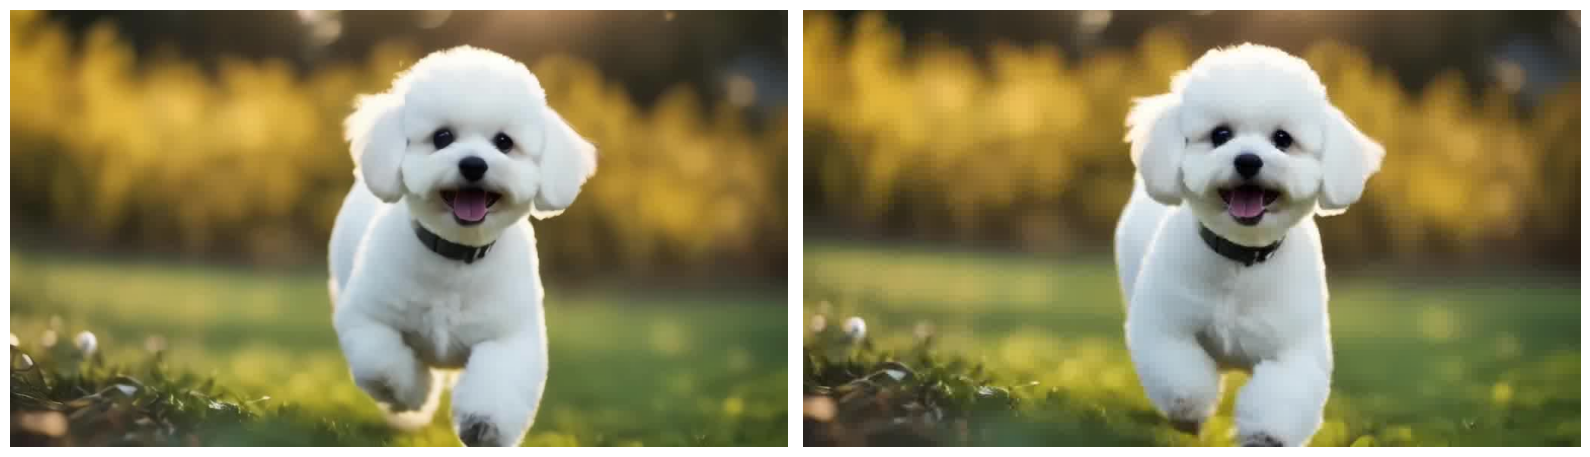

In [5]:
plt.figure(figsize=(16, 8), layout="tight")
plt.subplot(1, 2, 1)
plt.imshow(input_images[0][0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(input_images[1][0])
plt.axis("off");

## Load the model
[back to top ⬆️](#Table-of-contents:)

Model is loaded using `tensorflow_hub.KerasLayer` function. Then, we specify shapes of input tensors to cast loaded object to `tf.keras.Model` class.

Input tensors are:
- `time` - value between $[0,1]$ that says where the generated image should be. $0.5$ is midway between the input images.
- `x0` - initial frame.
- `x1` - final frame.

For more details, see [model page on TensorFlow Hub](https://tfhub.dev/google/film/1).

In [6]:
inputs = dict(
    x0=tf.keras.layers.Input(shape=(None, None, 3)),
    x1=tf.keras.layers.Input(shape=(None, None, 3)),
    time=tf.keras.layers.Input(shape=(1)),
)
model_url = "https://www.kaggle.com/models/google/film/frameworks/tensorFlow2/variations/film/versions/1"
film_layer = hub.KerasLayer(model_url)(inputs)
film_model = tf.keras.Model(inputs=inputs, outputs=film_layer)

## Infer the model
[back to top ⬆️](#Table-of-contents:)


### Single middle frame interpolation
[back to top ⬆️](#Table-of-contents:)


In [7]:
output = film_model(input)
interpolated_image = output["image"][0]
interpolated_image = np.clip(interpolated_image, 0, 1)

In [8]:
def draw(img1, mid_img, img2):
    title2img = {"First frame": img1, "Interpolated frame": mid_img, "Last frame": img2}
    plt.figure(figsize=(16,8), layout="tight")
    for i, (title, img) in enumerate(title2img.items()):
        ax = plt.subplot(1, 3, i + 1)
        ax.set_title(title)
        plt.imshow(img)
        plt.axis("off")

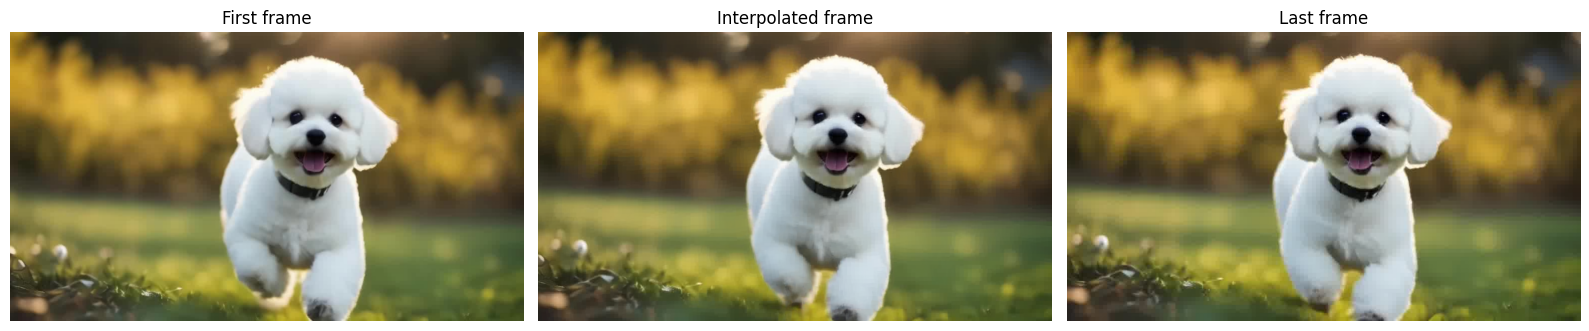

In [9]:
draw(input_images[0][0], interpolated_image, input_images[1][0])

### Recursive frame generation
[back to top ⬆️](#Table-of-contents:)

The process will take as input 2 original frames (first and last) and generate a midpoint frame. Then, it will repeat itself for pairs "first - midpoint", "midpoint - last" to provide midpoints for them, and so on. Recursion is executed $t=$ `times_to_interpolate` times generating $2^t-1$ images.

In [10]:
class Interpolator:
    def __init__(self, model):
        self._model = model

    def _recursive_generator(
        self,
        frame1: np.ndarray,
        frame2: np.ndarray,
        num_recursions: int,
        bar: Optional[tqdm] = None,
    ) -> Generator[np.ndarray, None, None]:
        """Splits halfway to repeatedly generate more frames.

        Args:
          frame1: Input image 1.
          frame2: Input image 2.
          num_recursions: How many times to interpolate the consecutive image pairs.

        Yields:
          The interpolated frames, including the first frame (frame1), but excluding
          the final frame2.
        """
        if num_recursions == 0:
            yield frame1
        else:
            time = np.array([[0.5]], dtype=np.float32)
            mid_frame = self._model({"x0": frame1, "x1": frame2, "time": time})["image"]
            if bar is not None:
                bar.update(1)
            yield from self._recursive_generator(frame1, mid_frame, num_recursions - 1, bar)
            yield from self._recursive_generator(mid_frame, frame2, num_recursions - 1, bar)

    def interpolate_recursively(
        self, frame1: np.ndarray, frame2: np.ndarray, times_to_interpolate: int
    ) -> Generator[np.ndarray, None, None]:
        """Generates interpolated frames by repeatedly interpolating the midpoint.

        Args:
          frame1: Input image 1.
          frame2: Input image 2.
          times_to_interpolate: Number of times to do recursive midpoint
            interpolation.

        Yields:
          The interpolated frames (including the inputs).
        """
        num_frames = 2 ** (times_to_interpolate) - 1
        bar = tqdm(total=num_frames)
        yield from self._recursive_generator(frame1, frame2, times_to_interpolate, bar)
        # Separately yield the final frame.
        yield frame2

In [11]:
def save_as_video(frames: Generator[np.ndarray, None, None], width: int, height: int, filename: Path):
    out = cv2.VideoWriter(str(filename), cv2.VideoWriter_fourcc(*'VP90'), 30, (width, height))
    for frame in frames:
        img = frame[0]
        img = np.clip(img, 0, 1)
        rgb_img = img * 255
        rgb_img = rgb_img.astype(np.uint8)
        bgr_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
        out.write(bgr_img)
    out.release()

In [12]:
height, width = input_images[0][0].shape[:2]
interpolator = Interpolator(film_model) 
frames = interpolator.interpolate_recursively(input_images[0], input_images[1], 5)
save_as_video(frames, width, height, OUTPUT_VIDEO_PATH)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
IPython.display.Video(filename=OUTPUT_VIDEO_PATH, embed=True)

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

To convert a TensorFlow Keras Model to OpenVINO Intermediate Representation (IR), call the `openvino.convert_model()` function and pass the model as the only argument. You can then serialize the model object to disk using the `openvino.save_model()` function.

In [14]:
if not MODEL_PATH.exists():
    converted_model = ov.convert_model(film_model)
    ov.save_model(converted_model, MODEL_PATH)
    del converted_model
del film_model
gc.collect()

1356

## Inference
[back to top ⬆️](#Table-of-contents:)


### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [15]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [16]:
compiled_model = core.compile_model(MODEL_PATH, device.value)

### Single middle frame interpolation
[back to top ⬆️](#Table-of-contents:)

Model output has multiple tensors, including auxiliary inference data. The main output tensor - interpolated image - is stored at "image" key.

In [17]:
result = compiled_model(input)["image"]
image = result[0]
image = np.clip(image, 0, 1)

Model returned intermediate image. Let's see what it is.

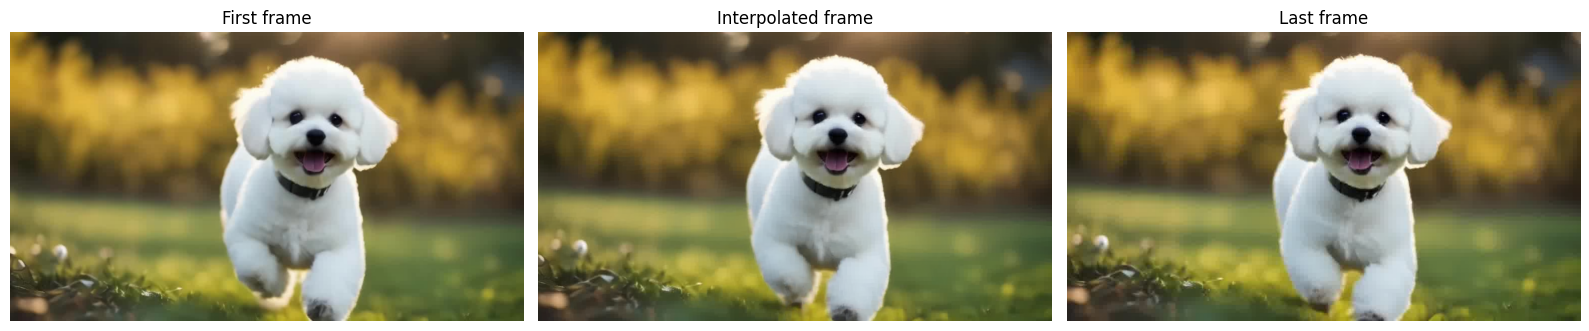

In [18]:
draw(input_images[0][0], image, input_images[1][0])

### Recursive frame generation
[back to top ⬆️](#Table-of-contents:)

Now let's create a smooth video by recursively generating frames between initial, middle and final images.

In [19]:
height, width = input_images[0][0].shape[:2]
ov_interpolator = Interpolator(compiled_model)
frames = ov_interpolator.interpolate_recursively(input_images[0], input_images[1], TIMES_TO_INTERPOLATE)
save_as_video(frames, width, height, OV_OUTPUT_VIDEO_PATH)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


  0%|          | 0/31 [00:00<?, ?it/s]

In [20]:
IPython.display.Video(filename=OV_OUTPUT_VIDEO_PATH, embed=True)

## Interactive inference
[back to top ⬆️](#Table-of-contents:)


In [ ]:
def generate(frame1, frame2, times_to_interpolate, _=gr.Progress(track_tqdm=True)):
    x0, x1 = [preprocess_np_frame(frame) for frame in [frame1, frame2]]
    frames = ov_interpolator.interpolate_recursively(x0, x1, times_to_interpolate)
    height, width = frame1.shape[:2]
    filename = DATA_PATH / f"output_{datetime.now().isoformat()}.webm"
    save_as_video(frames, width, height, filename)
    return filename

demo = gr.Interface(
    generate,
    [
        gr.Image(label="First image"),
        gr.Image(label="Last image"),
        gr.Slider(1, 8, step=1, label="Times to interpolate", info="""Controls the number of times the frame interpolator is invoked.
        The output will be the interpolation video with (2^value + 1) frames, fps of 30.""")
    ],
    gr.Video(),
    examples=[[*IMAGES.values(), 5]],
    allow_flagging="never"
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/